In [1]:
from io import StringIO

import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
from loguru import logger
import yaml

from datetime import datetime
import polars as pl
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# MODEL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import (
    LabelEncoder, 
    StandardScaler,
    label_binarize
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve
)

# Save variables for model
import joblib

# PERSONAL FUNCTIONS
from utils import *
from models.main import *
from functions.windows import create_feature_windows # creación de ventanas e ingenieria de características

In [2]:
df_accel = pl.read_csv(r"F:\UPC\Tesis\HARbit-Model\src\test\data\Watch_accelerometer.csv")
df_gyro = pl.read_csv(r"F:\UPC\Tesis\HARbit-Model\src\test\data\Watch_gyroscope.csv")

In [3]:
df_accel = normalize_columns(df_accel, 
                            user_col_name  = "User", 
                            timestamp_col_name = "Creation_Time", 
                            label_col_name = "gt", 
                            x_col_name = "x", 
                            y_col_name = "y", 
                            z_col_name = "z")

df_gyro = normalize_columns(df_gyro, 
                            user_col_name  = "User", 
                            timestamp_col_name = "Creation_Time", 
                            label_col_name = "gt", 
                            x_col_name = "x", 
                            y_col_name = "y", 
                            z_col_name = "z")

In [4]:
df_accel = convert_timestamp(df_accel)
df_gyro = convert_timestamp(df_gyro)

In [5]:
df_all_sensors = df_gyro.join(df_accel, on = ['Subject-id', 'Timestamp', 'Activity Label'], how = "inner")

In [6]:
df_gyro_inner = df_all_sensors.select(
            pl.col('Subject-id'), 
            pl.col('Timestamp'), 
            pl.col('Activity Label'),
            pl.col('X'), 
            pl.col('Y'), 
            pl.col('Z')
        )

df_accel_inner = df_all_sensors.select(
            pl.col('Subject-id'), 
            pl.col('Timestamp'), 
            pl.col('Activity Label'),
            pl.col('X_right').alias('X'), 
            pl.col('Y_right').alias('Y'), 
            pl.col('Z_right').alias('Z')
        )

In [31]:
stats_summary = df_accel.group_by(['Subject-id', 'Activity Label']).agg([
    # Estadísticas básicas
    pl.col('X').min().alias('X_min'),
    pl.col('X').max().alias('X_max'),
    pl.col('X').mean().alias('X_mean'),
    # pl.col('X').std().alias('X_std'),
    # pl.col('X').median().alias('X_median'),
    
    pl.col('Y').min().alias('Y_min'),
    pl.col('Y').max().alias('Y_max'),
    pl.col('Y').mean().alias('Y_mean'),
    # pl.col('Y').std().alias('Y_std'),
    # pl.col('Y').median().alias('Y_median'),
    
    pl.col('Z').min().alias('Z_min'),
    pl.col('Z').max().alias('Z_max'),
    pl.col('Z').mean().alias('Z_mean'),
    # pl.col('Z').std().alias('Z_std'),
    # pl.col('Z').median().alias('Z_median'),
    
    # Métricas adicionales
    # pl.count().alias('sample_count'),
    # pl.col('Timestamp').min().alias('start_time'),
    # pl.col('Timestamp').max().alias('end_time')
]).sort(['Subject-id', 'Activity Label'])

print("📊 ESTADÍSTICAS COMPLETAS POR USUARIO-ACTIVIDAD:")
stats_summary.write_excel(r"C:\Users\HP\Downloads\stats_summary_accel.xlsx")

📊 ESTADÍSTICAS COMPLETAS POR USUARIO-ACTIVIDAD:


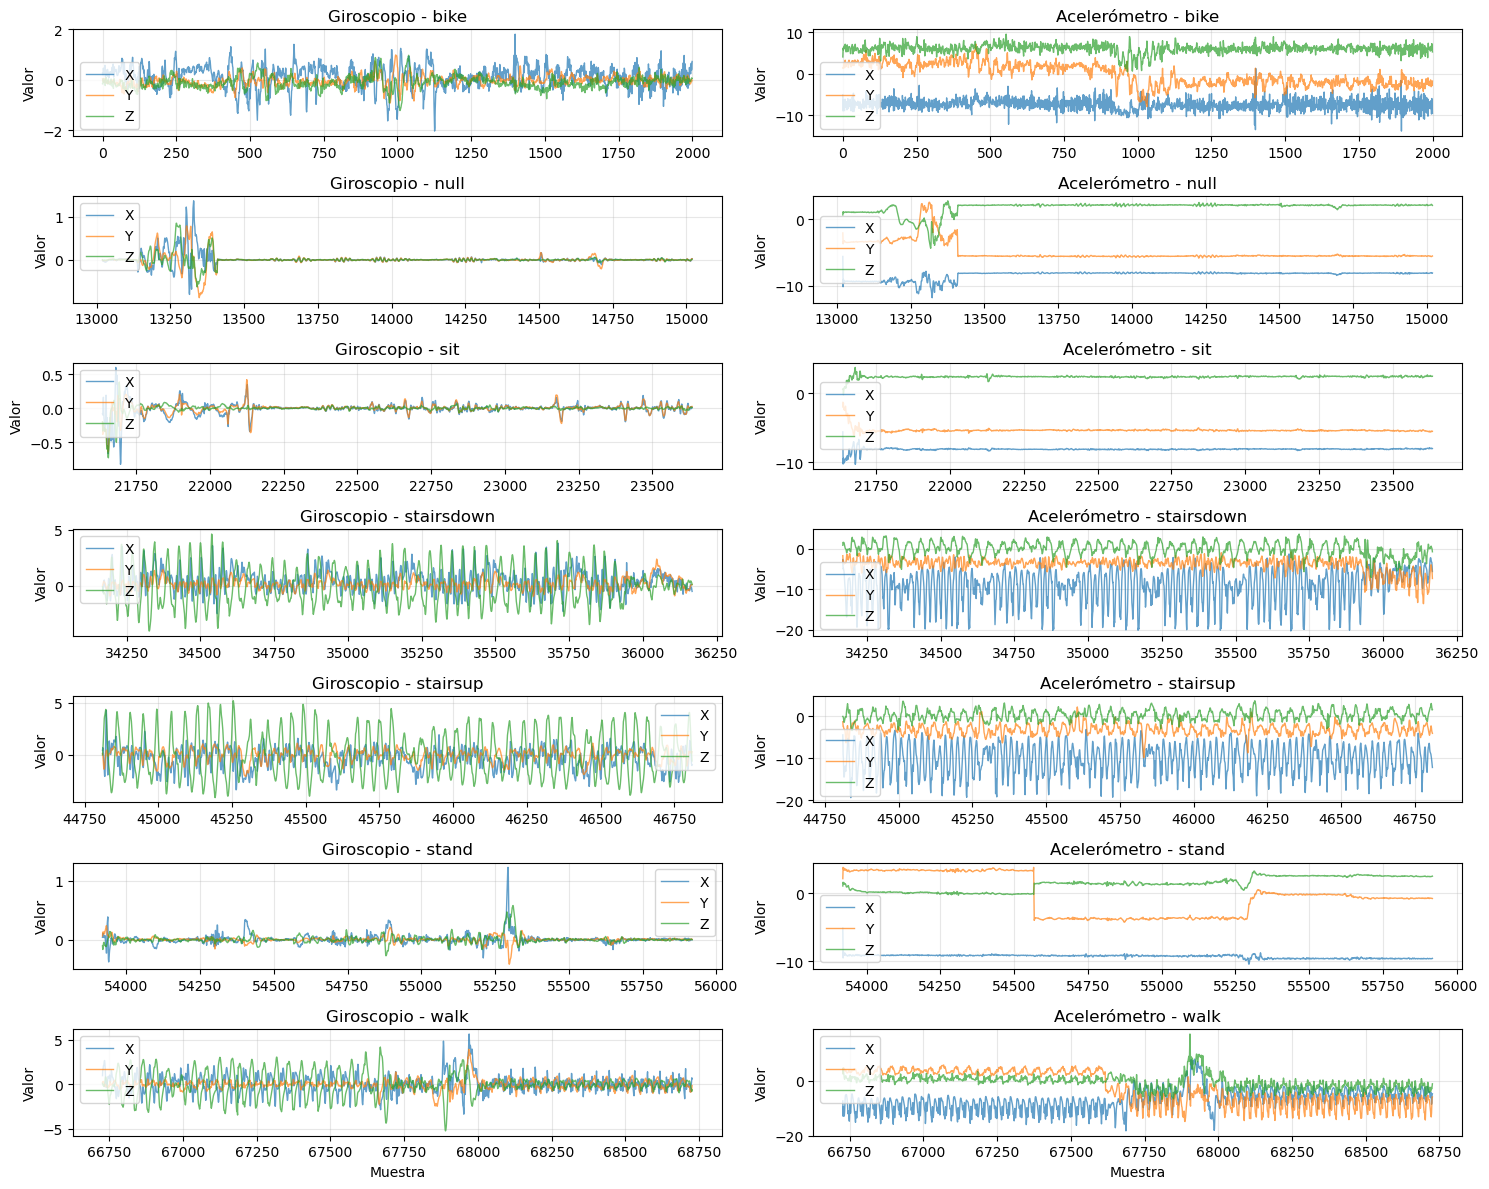

In [10]:
def plot_axes_by_activity(df_gyro, df_accel, max_samples_per_activity=1000, figsize=(15, 12), id_user = 'a'):
    """
    Visualiza los ejes X, Y, Z del giroscopio y acelerómetro por cada actividad
    """

    df_gyro     = df_gyro[df_gyro['Subject-id']     ==      id_user]
    df_accel    = df_accel[df_accel['Subject-id']   ==      id_user]

    # Obtener actividades únicas
    activities = df_gyro['Activity Label'].unique().tolist()
    n_activities = len(activities)
    
    # Crear subplots
    fig, axes = plt.subplots(n_activities, 2, figsize=figsize)
    if n_activities == 1:
        axes = axes.reshape(1, -1)
    
    for i, activity in enumerate(activities):
        # Filtrar datos por actividad
        gyro_activity = df_gyro[df_gyro['Activity Label'] == activity]
        accel_activity =  df_accel[df_accel['Activity Label'] == activity]
        
        # Limitar muestras para mejor visualización
        if len(gyro_activity) > max_samples_per_activity:
            gyro_activity = gyro_activity.head(max_samples_per_activity)
        if len(accel_activity) > max_samples_per_activity:
            accel_activity = accel_activity.head(max_samples_per_activity)
        
        # Convertir a pandas para plotting
        gyro_pd = gyro_activity.copy()
        accel_pd = accel_activity.copy()
        
        # Plot Giroscopio
        axes[i, 0].plot(gyro_pd['X'], label='X', alpha=0.7, linewidth=1)
        axes[i, 0].plot(gyro_pd['Y'], label='Y', alpha=0.7, linewidth=1)
        axes[i, 0].plot(gyro_pd['Z'], label='Z', alpha=0.7, linewidth=1)
        axes[i, 0].set_title(f'Giroscopio - {activity}')
        axes[i, 0].set_ylabel('Valor')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        # Plot Acelerómetro
        axes[i, 1].plot(accel_pd['X'], label='X', alpha=0.7, linewidth=1)
        axes[i, 1].plot(accel_pd['Y'], label='Y', alpha=0.7, linewidth=1)
        axes[i, 1].plot(accel_pd['Z'], label='Z', alpha=0.7, linewidth=1)
        axes[i, 1].set_title(f'Acelerómetro - {activity}')
        axes[i, 1].set_ylabel('Valor')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)
        
        # Añadir xlabel solo en la última fila
        if i == n_activities - 1:
            axes[i, 0].set_xlabel('Muestra')
            axes[i, 1].set_xlabel('Muestra')
    
    plt.tight_layout()
    plt.show()

# Ejecutar visualización
plot_axes_by_activity(df_gyro_group.to_pandas(), df_accel_group.to_pandas(), max_samples_per_activity = 2000, id_user = 'a')

In [8]:
df_gyro_group   = convert_freq_antialias(df_gyro_inner, hz = 20, orig_hz = 100)
df_accel_group  = convert_freq_antialias(df_accel_inner, hz = 20, orig_hz = 100)

In [40]:
features_gyro   = create_feature_windows(df_gyro_group, window_seconds = 5, overlap_percent=50, sampling_rate = 20)
features_accel  = create_feature_windows(df_accel_group, window_seconds = 5, overlap_percent=50, sampling_rate = 20)

In [ ]:
# features_gyro.to_csv(r"..\data\preprocess\UCI_gyro_50%-overlaping_5s-windows.csv", index = False)
# features_accel.to_csv(r"..\data\preprocess\UCI_accel_50%-overlaping_5s-windows.csv", index = False)

In [42]:
features_gyro = pd.read_csv(r"..\data\preprocess\UCI_gyro_50%-overlaping_5s-windows.csv")
features_accel = pd.read_csv(r"..\data\preprocess\UCI_accel_50%-overlaping_5s-windows.csv")

In [43]:
features_combined = pd.merge(
    features_gyro,
    features_accel,
    on=['Subject-id', 'Activity Label', 'window_start', 'window_end', 'sample_count'], 
    how="inner"
)

In [45]:
ls_columns_gyro = [col for col in features_combined.columns if col.endswith('_x')]
ls_columns_accel = [col for col in features_combined.columns if col.endswith('_y')]

In [46]:
features_combined = features_combined.drop(columns = ls_columns_gyro)

In [ ]:
from tensorflow import keras
model = keras.models.load_model(r'F:\UPC\Tesis\HARbit-Model\src\models\version\sensors\accel_cnn-lstm_wisdm_91_cluster_user.h5')
label_encoder = joblib.load(r'F:\UPC\Tesis\HARbit-Model\src\models\meta\sensors\accel_cnn-lstm_wisdm_91_cluster_user.joblib')

In [47]:
activities_dict = {
    'Walk': ['walk'],
    'Stairs': ['stairsup', 'stairsdown'],
    'Stand': ['stand'],
    'Sit': ['sit'],
    'Others': ['null', 'bike']
}

for activity in activities_dict.keys():
    for old_activity in activities_dict[activity]:
        features_combined.loc[features_combined['Activity Label'] == old_activity, 'Activity Label'] = activity

In [48]:
features_combined = features_combined[features_combined['Activity Label'] != 'Others']

In [49]:
data_train, data_test, data_val = split_by_user(features_combined, num_user_test = 2, num_user_val = 2)

In [51]:
X_train, y_train, subjects_train, label_encoder = prepare_features_for_cnn_lstm_sequences(
    data_train, 
    group_size=8, 
    step_size=1
)

print(f"Forma de X (secuencias): {X_train.shape}")   # (N, group_size, features)
print(f"Forma de y: {y_train.shape}")
print(f"Actividades únicas: {np.unique(y_train)}")

✅ Secuencias creadas: (1648, 8, 68)
  Num features: 68
  Clases: ['Sit' 'Stairs' 'Stand' 'Walk']
Forma de X (secuencias): (1648, 8, 68)
Forma de y: (1648,)
Actividades únicas: [0 1 2 3]


In [52]:
X_test, y_test, subjects_test, le1 = prepare_features_for_cnn_lstm_sequences(
    data_test,
    group_size=8,
    step_size=1
)

print(f"Forma de X (secuencias): {X_test.shape}")   # (N, group_size, features)
print(f"Forma de y: {y_test.shape}")
print(f"Actividades únicas: {np.unique(y_test)}")

✅ Secuencias creadas: (567, 8, 68)
  Num features: 68
  Clases: ['Sit' 'Stairs' 'Stand' 'Walk']
Forma de X (secuencias): (567, 8, 68)
Forma de y: (567,)
Actividades únicas: [0 1 2 3]


In [53]:
y_test = le1.inverse_transform(y_test)

In [54]:
X_val, y_val, subjects_test, le2 = prepare_features_for_cnn_lstm_sequences(
    data_val,
    group_size=8,
    step_size=1
)

print(f"Forma de X (secuencias): {X_val.shape}")   # (N, group_size, features)
print(f"Forma de y: {y_val.shape}")
print(f"Actividades únicas: {np.unique(y_val)}")

✅ Secuencias creadas: (1044, 8, 68)
  Num features: 68
  Clases: ['Sit' 'Stairs' 'Stand' 'Walk']
Forma de X (secuencias): (1044, 8, 68)
Forma de y: (1044,)
Actividades únicas: [0 1 2 3]


In [56]:
y_val = le2.inverse_transform(y_val)

In [57]:
y_test  = label_encoder.transform(y_test)
y_val   = label_encoder.transform(y_val)

In [ ]:
# X, y, subjects, label_encoder = prepare_features_for_cnn_lstm_sequences(
#     features_combined, 
#     group_size=8, 
#     step_size=1
# )

# print(f"Forma de X (secuencias): {X.shape}")   # (N, group_size, features)
# print(f"Forma de y: {y.shape}")
# print(f"Actividades únicas: {np.unique(y)}")

In [58]:
from models.main import *
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(label_encoder.classes_)

model = create_cnn_lstm_model(input_shape = input_shape, num_classes = num_classes)

c:\Users\HP\miniconda3\envs\forecasting\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
# Entrenar modelo
print("Entrenando modelo CNN-LSTM...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Entrenando modelo CNN-LSTM...
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8610 - loss: 0.4114 - val_accuracy: 0.8056 - val_loss: 0.7137 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9757 - loss: 0.0777 - val_accuracy: 0.8362 - val_loss: 0.4845 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9891 - loss: 0.0346 - val_accuracy: 0.8161 - val_loss: 0.3974 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9891 - loss: 0.0290 - val_accuracy: 0.9071 - val_loss: 0.2926 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9915 - loss: 0.0281 - val_accuracy: 0.7969 - val_loss: 0.8689 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9897 - loss: 0.0299 - val_accuracy: 0.7893 - val_loss: 0.7836 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accu

Evaluando modelo...
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

Pérdida en test: 0.2624
Precisión en test: 0.9277

REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

         Sit     0.7891    1.0000    0.8821       116
      Stairs     0.9761    0.9714    0.9737       210
       Stand     1.0000    0.7458    0.8544       118
        Walk     0.9593    0.9593    0.9593       123

    accuracy                         0.9277       567
   macro avg     0.9311    0.9191    0.9174       567
weighted avg     0.9392    0.9277    0.9270       567



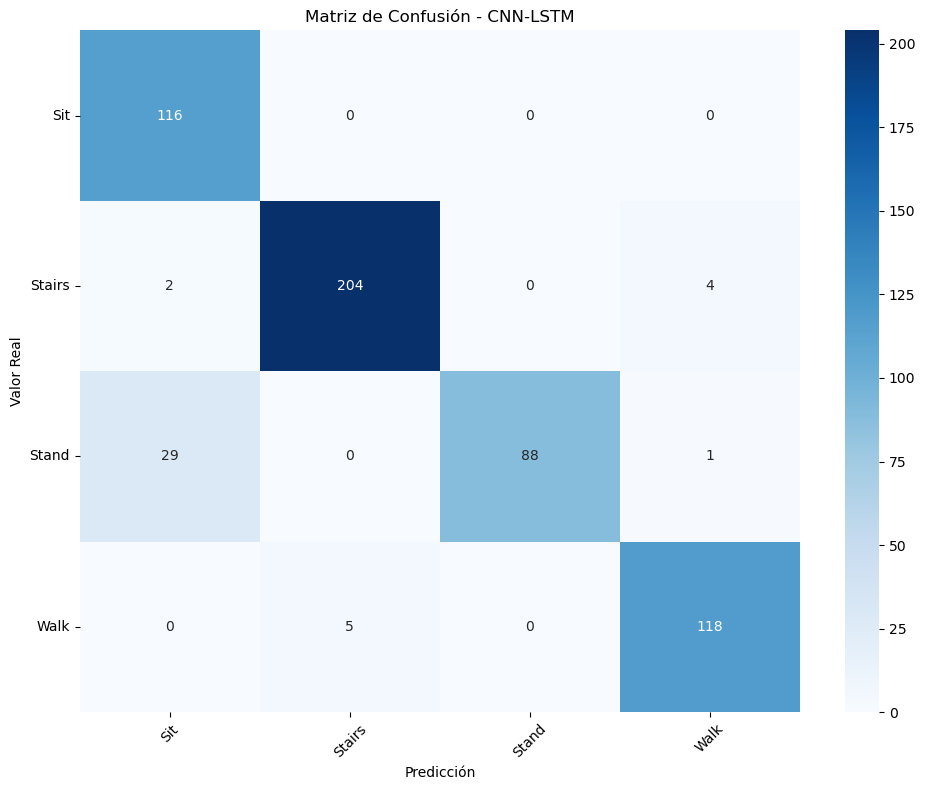

In [60]:
print("Evaluando modelo...")

# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas básicas
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPérdida en test: {test_loss:.4f}")
print(f"Precisión en test: {test_accuracy:.4f}")

# Reporte de clasificación detallado
print("\n" + "="*50)
print("REPORTE DE CLASIFICACIÓN")
print("="*50)
print(classification_report(
    y_test, 
    y_pred_classes, 
    target_names=label_encoder.classes_,
    digits=4
))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matriz de Confusión - CNN-LSTM')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [62]:
from tensorflow import keras

model.save(r'F:\UPC\Tesis\HARbit-Model\src\models\cnn-lstm_uci_user_92.h5')
joblib.dump(label_encoder, r'F:\UPC\Tesis\HARbit-Model\src\models\meta\label_encoder_user_uci_92.joblib')

['F:\\UPC\\Tesis\\HARbit-Model\\src\\models\\meta\\label_encoder_user_uci_92.joblib']